In [2]:
# %% imports
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
# %% define classifier
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """

    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x,
                                      weights=self.weights)),
                axis=1,
                arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = []
        for clf in self.classifiers_:
            if hasattr(clf, "predict_proba"):
                array = np.array(clf.predict_proba(X))
                probas.append(array)
            else:
                array = np.array(clf.predict(X)[0])
                probas.append(array)

        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

#  Using the majority voting principle to make predictions

       LeagueIndex  UniqueUnitsMade  UniqueHotkeys          Age  HoursPerWeek  \
count  3338.000000      3338.000000    3338.000000  3338.000000   3338.000000   
mean      0.437388         6.541043       4.316357    21.650389     15.909527   
std       0.496139         1.859049       2.333322     4.206357     11.964495   
min       0.000000         2.000000       0.000000    16.000000      0.000000   
25%       0.000000         5.000000       3.000000    19.000000      8.000000   
50%       0.000000         6.000000       4.000000    21.000000     12.000000   
75%       1.000000         8.000000       6.000000    24.000000     20.000000   
max       1.000000        13.000000      10.000000    44.000000    168.000000   

           TotalHours          APM  GapBetweenPACs  ActionLatency  \
count     3338.000000  3338.000000     3338.000000    3338.000000   
mean       960.421809   114.575763       40.713819      64.209584   
std      17318.133922    48.111912       17.057191      19.0373

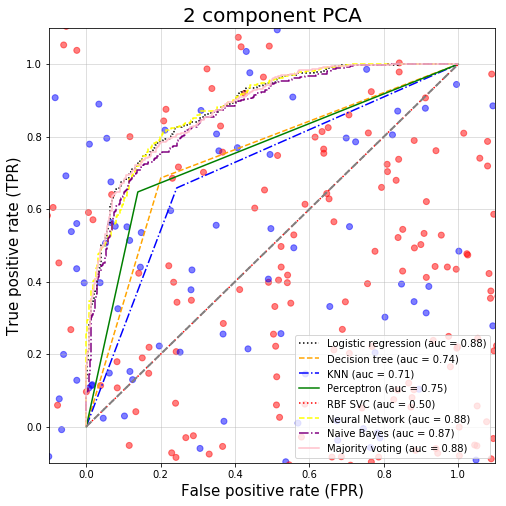

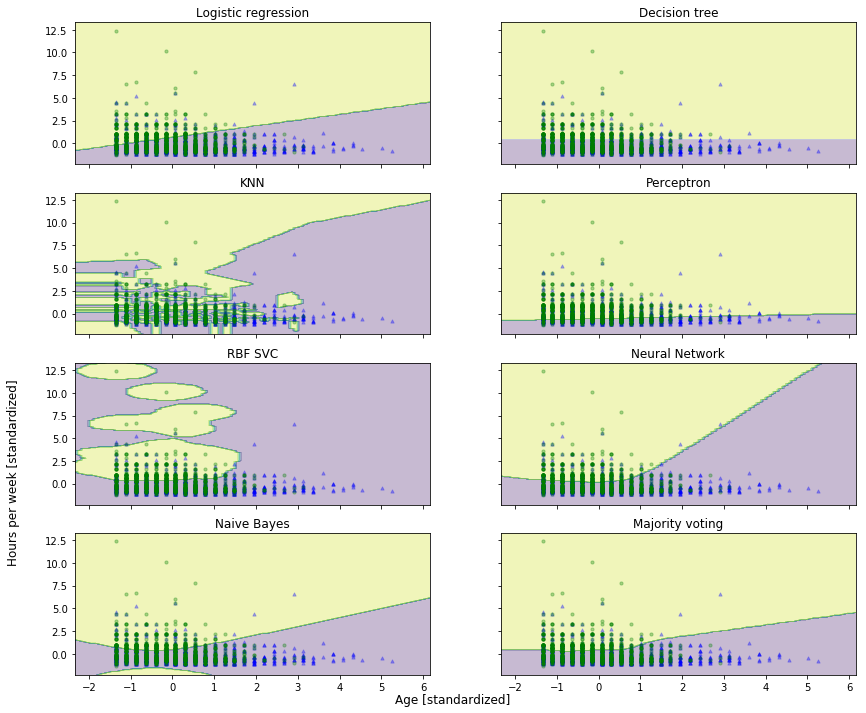

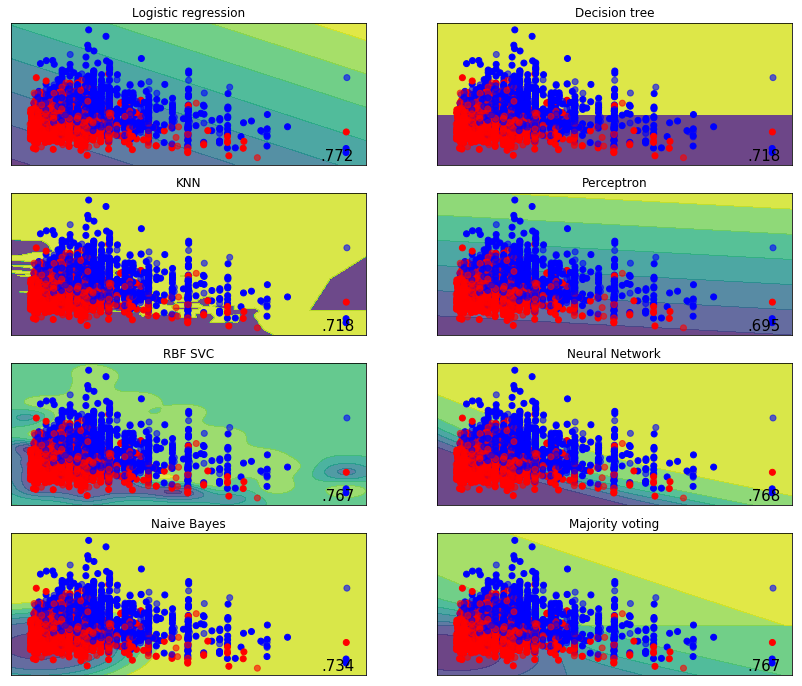

In [4]:
# %% import data
df = pd.read_csv('Skill.csv')

# %% explore data
print(df.describe())
df2 = df[df['TotalHours'] < 5000]
df2.describe()

# %% explore data
X, y = df2.iloc[:, 1:], df2.iloc[:, 0]

# %% PCA
pca = PCA(n_components=2)
X, y = df2.iloc[:, 1:], df2.iloc[:, 0]
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)
h = 0.02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

cm_bright = ListedColormap(['#FF0000', '#0000FF'])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)
ax.grid()

# %% train test split
X, y = df2.iloc[:, 1:], df2.iloc[:, 0]
print(y.sum() / y.size)
print(1 - y.sum() / y.size)
# print(df2.describe())

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=1,
                                                    stratify=y)

# %% define classifiers and pipes
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
clf4 = Perceptron()
clf5 = SVC(kernel='rbf', gamma=2, C=1)
clf6 = MLPClassifier(hidden_layer_sizes=(50, 25), alpha=1)
clf7 = GaussianNB()

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
pipe4 = Pipeline([['sc', StandardScaler()], ['clf', clf4]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', clf5]])
pipe6 = Pipeline([['sc', StandardScaler()], ['clf', clf6]])
pipe7 = Pipeline([['sc', StandardScaler()], ['clf', clf7]])

clf_labels = ['Logistic regression', 'Decision tree',
              'KNN', 'Perceptron', 'RBF SVC',
              'Neural Network', 'Naive Bayes']

# %% Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3, pipe4, pipe5, pipe6, pipe7])

clf_labels += ['Majority voting']

all_clf = [pipe1, clf2, pipe3, pipe4, pipe5, pipe6, pipe7, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

# %% Accuracy
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3, pipe4, pipe5, pipe6, pipe7])
all_clf = [pipe1, clf2, pipe3, pipe4, pipe5, pipe6, pipe7, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

# %% Prune1
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe4, pipe6, pipe7])
all_clf = [pipe1, clf2, pipe3, pipe4, pipe5, pipe6, pipe7, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

# Prune2
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe4, pipe6, pipe7])
all_clf = [pipe1, clf2, pipe3, pipe4, pipe5, pipe6, pipe7, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

# %% Plotting decision boundaries first two principal components
# Evaluating and tuning the ensemble classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe4, pipe6, pipe7])

colors = ['black', 'orange', 'blue', 'green', 'red', 'yellow', 'purple', 'pink']  ## <- fix here
linestyles = [':', '--', '-.', '-', ':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf,
                               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    if hasattr(clf, "predict_proba"):
        y_pred = clf.fit(X_train,
                         y_train).predict_proba(X_test)[:, 1]
    else:
        y_pred = clf.fit(X_train,
                         y_train).predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

# plt.savefig('images/07_04', dpi=300)
plt.show()

# In[65]:


sc = StandardScaler()
X_train_std = sc.fit_transform(X_train.iloc[:, [2, 3]])

# In[66]:
all_clf = [pipe1, clf2, pipe3, pipe4, pipe5, pipe6, pipe7, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=4, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(14, 12))

for idx, clf, tt in zip(product([0, 1, 2, 3], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c='blue',
                                  marker='^',
                                  s=10,
                                  alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c='green',
                                  marker='o',
                                  s=10,
                                  alpha=0.3)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Age [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-14, 20,
         s='Hours per week [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

# plt.savefig('images/07_05', dpi=300)
plt.show()

# In[67]:


from itertools import product

pca = PCA(n_components=2)

X = pca.fit_transform(X)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

h = .02
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
i = 1

f, axarr = plt.subplots(nrows=4, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(14, 12))

for idx, clf, name in zip(product([0, 1, 2, 3], [0, 1]),
                          all_clf, clf_labels):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=.8)

    # Plot also the training points
    axarr[idx[0], idx[1]].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    axarr[idx[0], idx[1]].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                                  alpha=0.6)

    axarr[idx[0], idx[1]].set_xlim(xx.min(), xx.max())
    axarr[idx[0], idx[1]].set_ylim(yy.min(), yy.max())
    axarr[idx[0], idx[1]].set_xticks(())
    axarr[idx[0], idx[1]].set_yticks(())
    axarr[idx[0], idx[1]].set_title(name)
    axarr[idx[0], idx[1]].text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'),
                               size=15, horizontalalignment='right')
    i += 1
plt.show()

In [ ]:
W